# Hierarchical Probabilistic U-Net

Copyright 2019 DeepMind Technologies Limited

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

#Colab: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deepmind/deepmind-research/blob/master/hierarchical_probabilistic_unet/HPU_Net.ipynb)
If you haven't already opened this notebook in colab, you can click the button above to open it there.

In [0]:
!pip install tensorflow==1.14.0
!pip install tensorflow-probability==0.7.0
!pip install dm-sonnet==1.35

from glob import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import os
import tensorflow as tf
import sonnet as snt

# Clone github repo

In [0]:
!git clone https://github.com/deepmind/deepmind-research.git deepmind_research
%cd deepmind_research/hierarchical_probabilistic_unet
from model import HierarchicalProbUNet


# Load LIDC test data from Google Cloud Storage

In [0]:
!gsutil cp gs://hpunet-data/lidc_crops/test.tar.gz /tmp/
!tar xvfz /tmp/test.tar.gz -C /tmp/

# Load pretrained weights from Google Cloud Storage

In [0]:
!gsutil cp gs://hpunet-data/model_checkpoint/checkpoint.tar.gz /tmp/
!tar xvfz /tmp/checkpoint.tar.gz -C /tmp/

In [0]:
#@title Utility to function to batch-up the data.

test_img_dir = '/tmp/test'

def make_batch(patient_ixs):
  """Assembles a batch of the first image for each specified patient.
  Args:
    patient_ixs: A list of integers specifying the patients to choose.
  Returns:
    A tuple holding the batched image of shape (b, 128, 128, 1) and the batched
    segmentations of shape (b, 128, 128, 4).
  """
  img, seg = [], []
  patient_dirs = glob(os.path.join(test_img_dir, 'images', '*'))
  for i in patient_ixs:
    # get the first image for the patient
    img_path = glob(os.path.join(patient_dirs[i], '*'))[0]
    image = matplotlib.image.imread(img_path)
    image = image[np.newaxis, ..., np.newaxis]
    img.append(image)
    # get the corresponding ground truth labels
    gt_base_path = img_path.replace('images', 'gt')
    labels = []
    for l in range(4):
      gt_path = gt_base_path.replace('.png', '_l{}.png'.format(l))
      label = matplotlib.image.imread(gt_path)
      labels.append(label[np.newaxis, ..., np.newaxis])
    labels = np.concatenate(labels, axis=-1)
    seg.append(labels)
  img_batch = np.concatenate(img, axis=0)
  seg_batch = np.concatenate(seg, axis=0)

  # The images and segmentations have a spatial shape of 180 x 180. Crop to
  # spatial shape 128 x 128.
  return img_batch[:, 26:-26, 26:-26], seg_batch[:, 26:-26, 26:-26]

# Run a pre-trained model on the LIDC Test Set.
First construct a graph for the model. Here we set-up different sampling configurations to examine the sampling behavior when different latent scales are fixed to their means.

---



In [0]:
tf.reset_default_graph()
hpu_net = HierarchicalProbUNet(name='model/HPUNet')

_GRADER_TO_RECONSTRUCT = 3
_NUM_SAMPLES = 16
_INSTANCE_INDICES = range(10)
_NUM_CLASSES = 2

img, seg = make_batch(patient_ixs=_INSTANCE_INDICES)
img_placeholder = tf.placeholder(shape=img.shape, dtype=tf.float32, name='img')
seg_placeholder = tf.placeholder(shape=seg.shape, dtype=tf.float32, name='seg')
seg_one_hot = tf.one_hot(tf.cast(seg[..., _GRADER_TO_RECONSTRUCT], tf.uint8),
                         depth=_NUM_CLASSES)
reconstruction = hpu_net.reconstruct(seg_one_hot, img_placeholder)
sample_full = hpu_net.sample(img_placeholder)
sample_local = hpu_net.sample(img_placeholder, mean=[1, 1, 1, 0])
sample_global = hpu_net.sample(img_placeholder, mean=[0, 1, 1, 1])

Restore the model from a checkpoint, run a reconstruction and the different sampling configurations.

In [0]:
saver = tf.train.Saver()
with tf.train.MonitoredTrainingSession() as sess:
  # restore checkpoint
  saver.restore(sess, '/tmp/checkpoint/tf_graph_data.ckpt')

  # sample from the full hierarchy
  rec, s = sess.run([reconstruction, sample_full],
                    feed_dict={img_placeholder: img, seg_placeholder: seg})

  samples = [s[..., np.newaxis]]
  if _NUM_SAMPLES > 1:
    for _ in range(_NUM_SAMPLES - 1):
      s = sess.run(sample_full, feed_dict={img_placeholder: img})
      samples.append(s[..., np.newaxis])
  samples = np.concatenate(samples, axis=-1)

  # sample from global latent only
  samples_global = []
  for _ in range(_NUM_SAMPLES):
    s = sess.run(sample_global, feed_dict={img_placeholder: img})
    samples_global.append(s[..., np.newaxis])
  samples_global = np.concatenate(samples_global, axis=-1)

  # sample from most local latents only
  samples_local = []
  for _ in range(_NUM_SAMPLES):
    s = sess.run(sample_local, feed_dict={img_placeholder: img})
    samples_local.append(s[..., np.newaxis])
  samples_local = np.concatenate(samples_local, axis=-1)

# Plot Examples.
Plot batches of images, the corresponding 4 segmentation masks, a posterior reconstruction of one of the masks as well as a number of samples.

In [0]:
#@title Utility functions for plotting.

def to_rgb(arr, cmap={0: (0, 0, 0), 1: (255, 255, 255)}):
    """
    Transform an integer-labeled segmentation map using an rgb color-map.
    :param arr: img_arr w/o a color-channel
    :param cmap: dictionary mapping from integer class labels to rgb values
    :return:
    """
    new_arr = np.zeros(shape=(arr.shape)+(3, ))
    for c in cmap.keys():
        ixs = np.where(arr == c)
        new_arr[ixs] = [cmap[c][i] / 255. for i in range(3)]
    return new_arr

def make_plot(img, seg, rec, samples, fs=6):
  """
  Make a grid plot of a batch of images, set of ground truth segmentations and
  corresponding reconstructions and samples. Each example is displayed in a 
  column of the plot.
  :img: Batch of images, array of shape (b, h, w, 1).
  :seg: Batch of segmentations, array of shape  (b, h, w, num_graders).
  :samples: Batch of samples, array of shape (b, h, w, num_classes,
   num_samples).
  :fs: Font size, integer.
  """
  num_samples = samples.shape[-1]
  num_graders = seg.shape[-1]
  bs = img.shape[0]
  num_rows = 1 + num_graders + 1 + num_samples

  f = plt.figure(figsize=(bs * fs, num_rows * fs))
  outer = gridspec.GridSpec(6, 1, wspace=0.1, hspace=0.1,
                            height_ratios=[1, num_graders, 1, num_samples, 1, 1])

  img_spec = gridspec.GridSpecFromSubplotSpec(
      1, bs, subplot_spec=outer[0], wspace=0.0, hspace=0.0)
  grader_spec = gridspec.GridSpecFromSubplotSpec(
      num_graders, bs, subplot_spec=outer[1], wspace=0.0, hspace=0.0)
  rec_spec = gridspec.GridSpecFromSubplotSpec(
      1, bs, subplot_spec=outer[2], wspace=0.0, hspace=0.0)
  sample_spec = gridspec.GridSpecFromSubplotSpec(
      num_samples, bs, subplot_spec=outer[3], wspace=0.0, hspace=0.0)
  grader_std_spec = gridspec.GridSpecFromSubplotSpec(
      1, bs, subplot_spec=outer[4], wspace=0.0, hspace=0.0)
  sample_std_spec = gridspec.GridSpecFromSubplotSpec(
      1, bs, subplot_spec=outer[5], wspace=0.0, hspace=0.0)
  for j in range(bs):
      # image
      ax = plt.subplot(img_spec[0, j])
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      plt.imshow(np.concatenate([img[j] for _ in range(3)], axis=-1))
      if j == 0:
        ax.annotate('CT scan', (-0.2, 0.5), xycoords='axes fraction',
                    va='center', rotation=90)
      # ground-truth
      for i in range(num_graders):
        ax = plt.subplot(grader_spec[i, j])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow(to_rgb(seg[j, ..., i]))
        if j == 0 and i == 1:
          ax.annotate('Graders', (-0.2, 0.0), xycoords='axes fraction',
                      va='center', rotation=90)
      # reconstruction
      ax = plt.subplot(rec_spec[0, j])
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      plt.imshow(to_rgb(np.argmax(rec[j], axis=-1)))
      if j == 0:
        ax.annotate('Reconstruction', (-0.2, 0.5), xycoords='axes fraction',
                    va='center', rotation=90)
      # samples
      if num_samples % 2 != 0:
        xy = (-0.2, 0.5)
      else:
        xy = (-0.2, 1.0)
      for i in range(num_samples):
        ax = plt.subplot(sample_spec[i, j])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow(to_rgb(np.argmax(samples[j, ..., i], axis=-1)))
        if j == 0 and i == num_samples // 2:
          ax.annotate('Samples', xy, xycoords='axes fraction',
                       va='center', rotation=90)

      # grader standard deviation
      ax = plt.subplot(grader_std_spec[0, j])
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      std = np.std(seg[j], axis=-1)
      plt.imshow(std, cmap=plt.get_cmap('jet'))
      if j == 0:
        ax.annotate('Grader', (-0.4, 0.5), xycoords='axes fraction',
                    va='center', rotation=90)
        ax.annotate('Std. Dev.', (-0.2, 0.5), xycoords='axes fraction',
                    va='center', rotation=90)

      # sample standard deviation
      ax = plt.subplot(sample_std_spec[0, j])
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      samples_argmax = np.argmax(samples[j], axis=-2)
      std = np.std(samples_argmax, axis=-1)
      plt.imshow(std, cmap=plt.get_cmap('jet'))
      if j == 0:
        ax.annotate('Samples', (-0.4, 0.5), xycoords='axes fraction',
                    va='center', rotation=90)
        ax.annotate('Std. Dev.', (-0.2, 0.5), xycoords='axes fraction',
                    va='center', rotation=90)

# Plot samples from the full hierarchy.
When sampling from the full hierarchy of the prior, none of the latent scales is constrained to their respective mean(s).

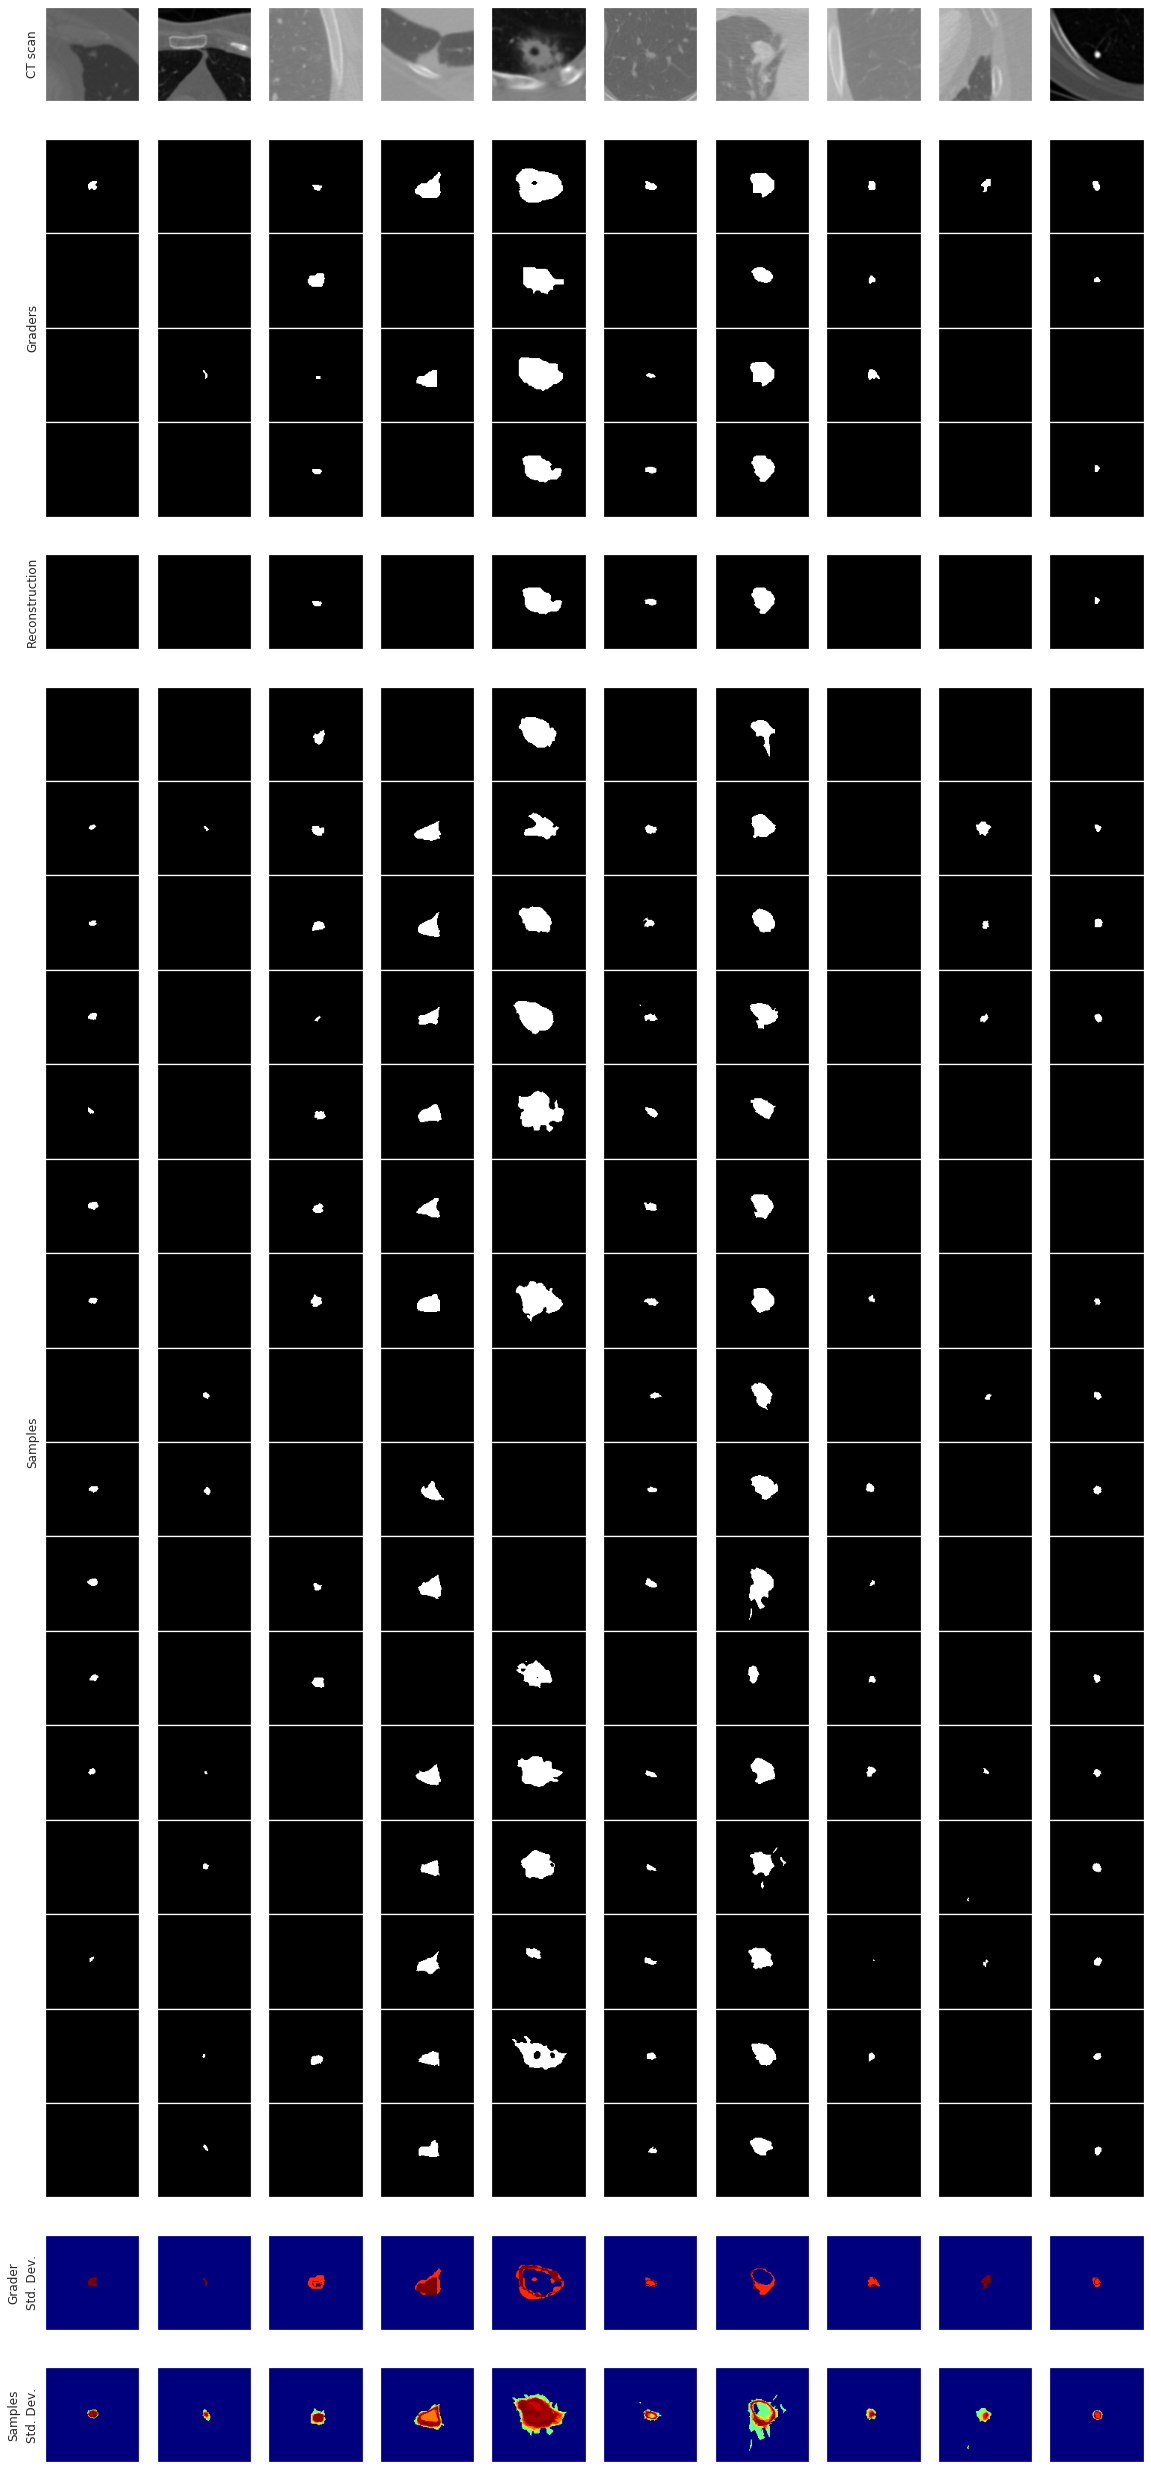

In [0]:
make_plot(img, seg, rec, samples, fs=2)

# Plot samples from the global latent only
When sampling from the global latent, all but the most global latent scale are constrained to their means.

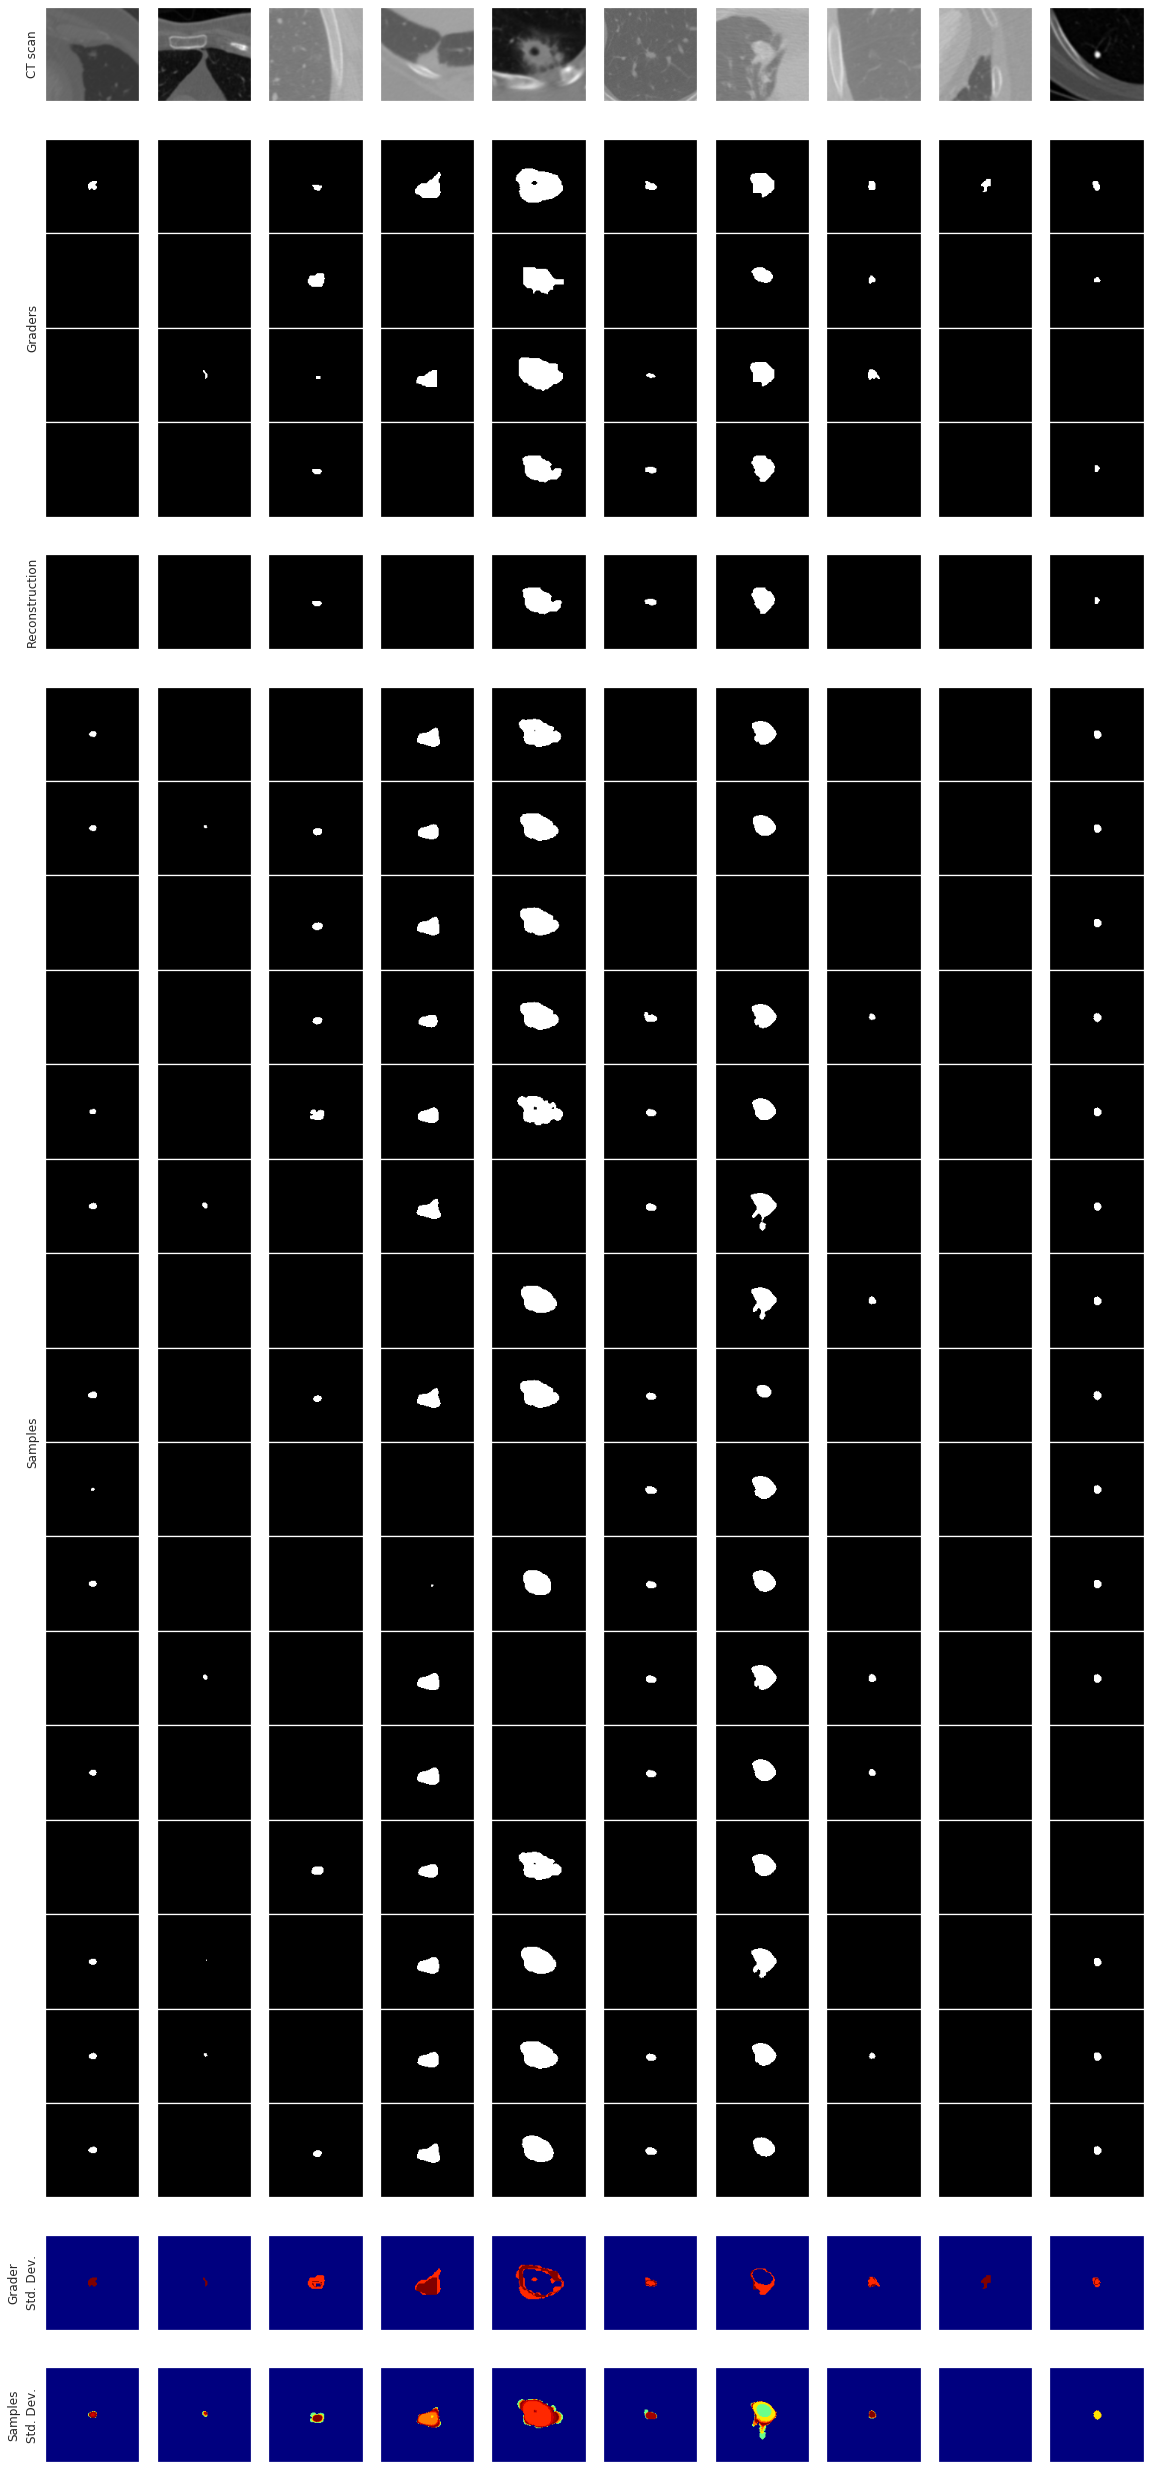

In [0]:
make_plot(img, seg, rec, samples_global, fs=2)

# Plot samples from the local latents only
When sampling from the local latents, all but the most local latent scales are constrained to their means.

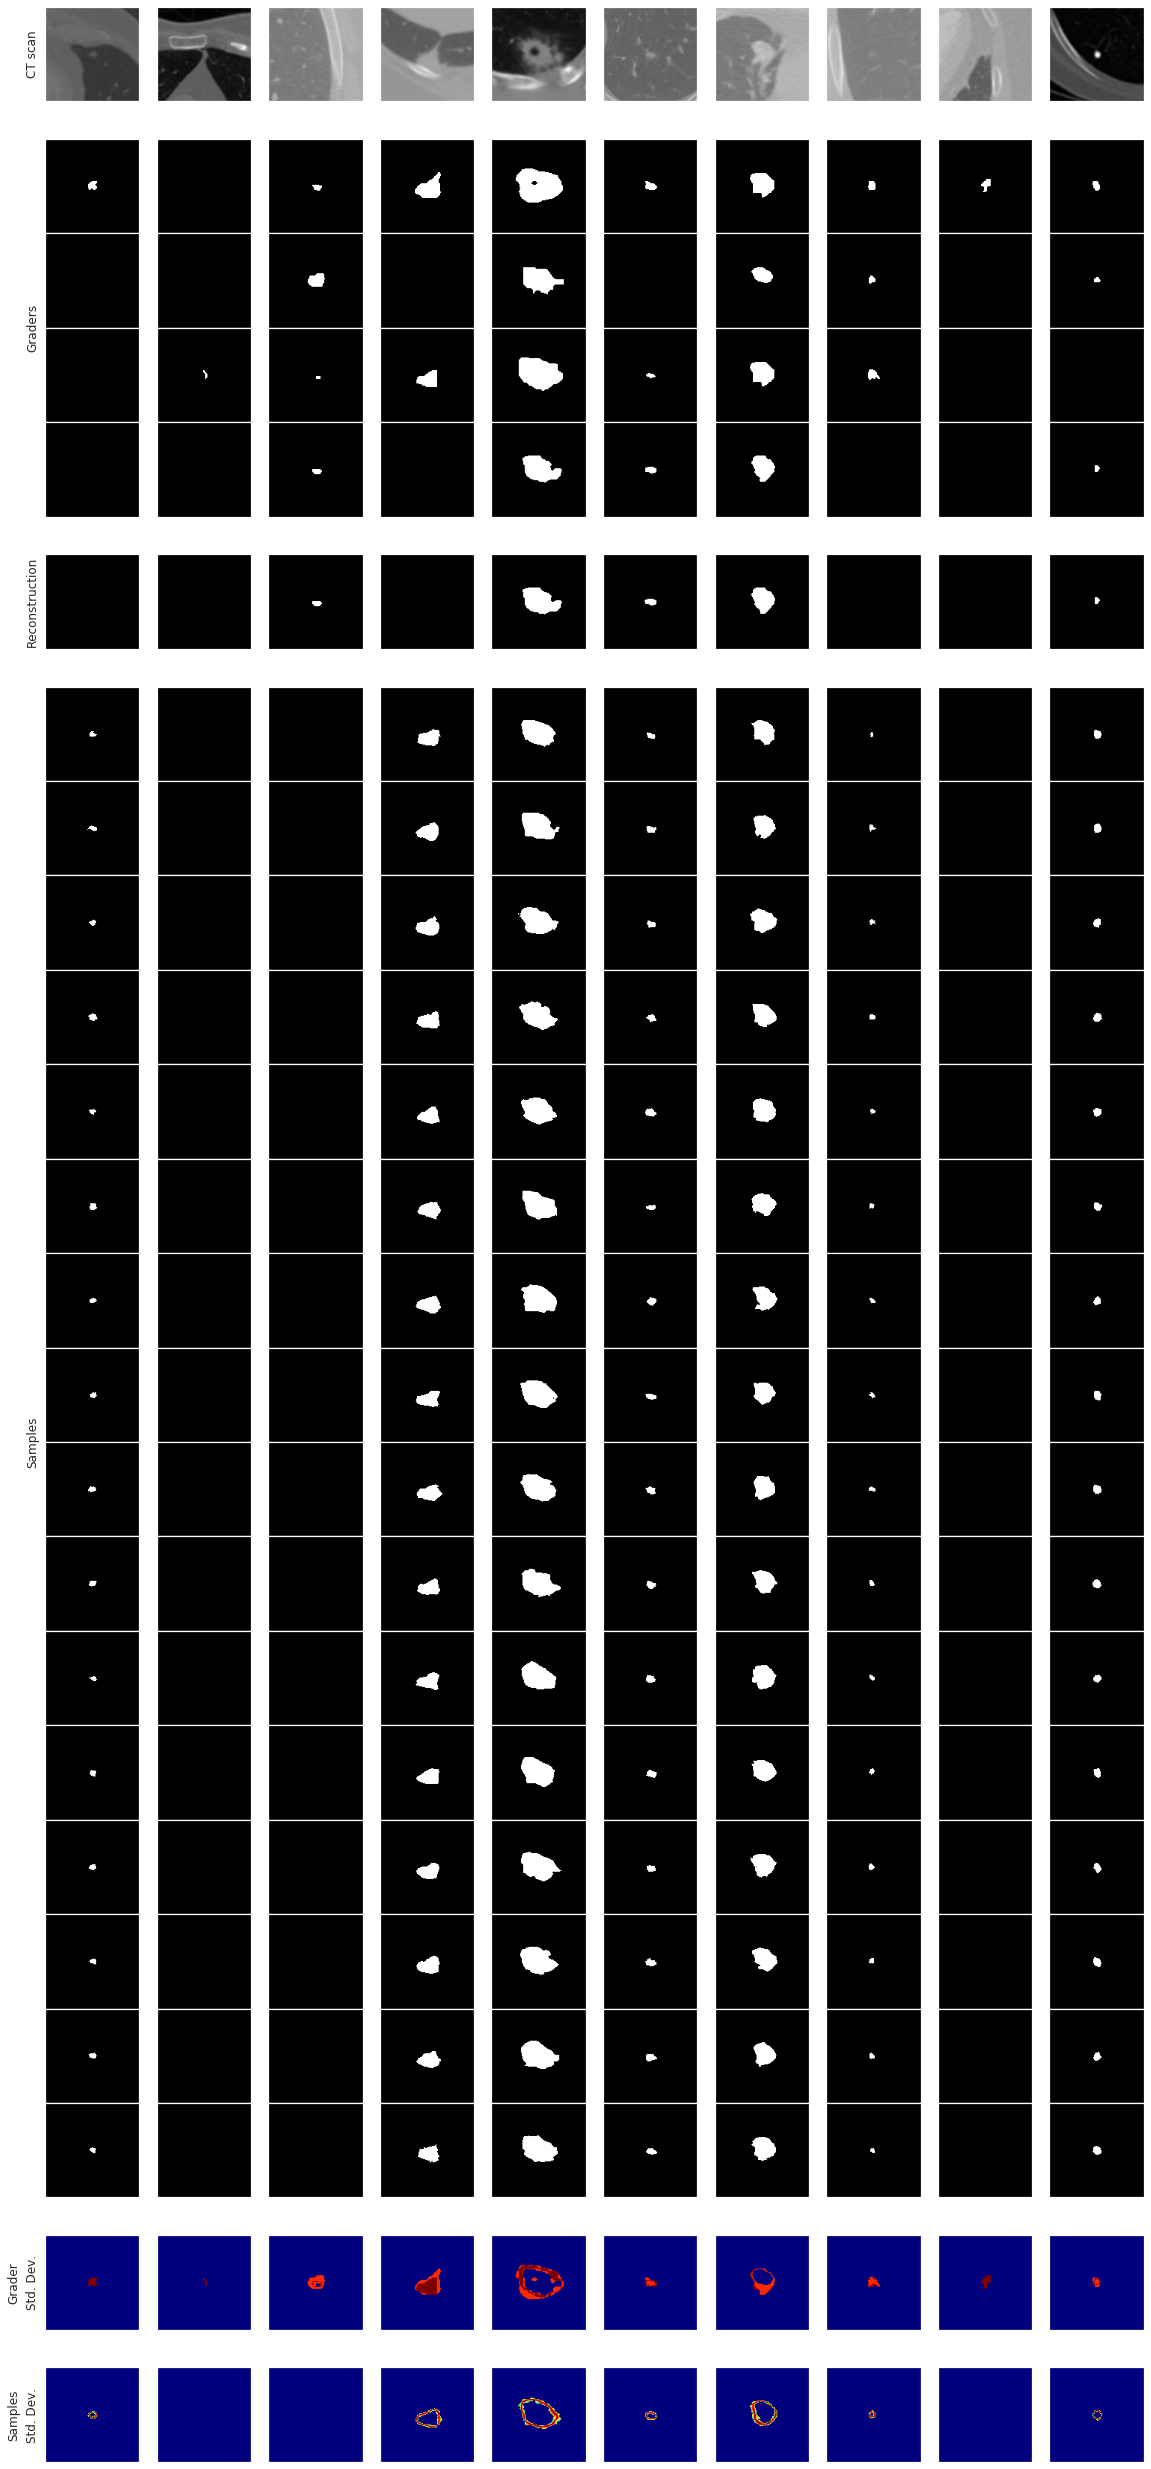

In [0]:
make_plot(img, seg, rec, samples_local, fs=2)
